In [1]:
import numpy as np
from lensing_data_class import LensingData
from cluster_local_tidy import ClusterLensing
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from cluster_local_new import ClusterLensing_fyp
import pandas as pd
import corner
import arviz as az
import pathlib

In [2]:
import warnings

# Suppressing the lenstronomy warning on astropy.cosmology
from lenstronomy.LensModel.lens_model import LensModel
warnings.filterwarnings("ignore", category=UserWarning, module='lenstronomy.LensModel.lens_model')

In [20]:


# --- 1. Create Dummy Lensing Data ---
# In a real scenario, you would load your FITS files or other data here.
# We'll create placeholder data for 2 clusters.
# The maps are small for this example (e.g., 200x200 pixels).

scenarios = {
        '1': 'abell370',
        '2': 'abell2744',
        '3': 'abells1063',
        '4': 'macs0416',
        '5': 'macs0717',
        '6': 'macs1149'
    }

full_cluster_names = {
        'abell370': 'Abell 370',
        'abell2744': 'Abell 2744',
        'abells1063': 'Abell S1063',
        'macs0416': 'MACS J0416.1-2403',
        'macs0717': 'MACS J0717.5+3745',
        'macs1149': 'MACS J1149.5+2223'
    }

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/diego/hlsp_frontier_model_{clustername}_diego_v4.1_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/diego/hlsp_frontier_model_{clustername}_diego_v4.1_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/diego/hlsp_frontier_model_{clustername}_diego_v4.1_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)

# getting the pixel scale list
pixscale_list = [0.42, 0.51, 0.51, 0.42, 0.42, 0.42]
lensing_data = LensingData(
    alpha_maps_x=datax_list,
    alpha_maps_y=datay_list,
    lens_potential_maps=data_psi_list,
    pixscale = pixscale_list,
    z_l_list = [0.375, 0.308, 0.351, 0.397, 0.545, 0.543], # Lens redshifts for the two clusters
    # We can use the default x_center, y_center, and search_window_list
    # or override them if needed.
)

# --- 3. Initialize the Main Analysis Class ---
# z_s_ref is a reference source redshift used for initial scaling calculations.
# It can be an estimate of the source's redshift.
z_s_ref = 1.5 
cluster_system = ClusterLensing(data=lensing_data, z_s_ref=z_s_ref)

print("Setup complete. Lensing system initialized.")

Setup complete. Lensing system initialized.


In [10]:
index, x,y,z,H0 = cluster_system.generate_source_positions(10,5,30,5)

In [11]:
print(f"Generated source positions: x={x}, y={y}, z={z}, H0={H0}")

Generated source positions: x=[105.73919003 110.25842448 106.84312785 105.94871171 108.17157775
 105.55251281 103.39779228  90.89189431 107.40122297 110.46905112], y=[113.28710226 110.99640813 113.52573426 113.89505427 111.85352272
 115.04496287 117.65680252  99.6342755  112.67808964 109.5072971 ], z=[2.51962764 3.1445004  2.26107163 2.13730066 3.56415274 2.20277056
 3.59049167 3.56741533 2.00564488 3.54220536], H0=[72.18428846 71.4727551  71.33932058 72.72427971 75.78916806 72.74323038
 70.78781617 70.70327785 73.65706632 70.50229372]


In [12]:
# store in a csv file for each element in the list
output_dir = pathlib.Path('.')
# check if the file exists, if not create it
output_file = output_dir / "src_pos_tidy.csv"
src = pd.read_csv(output_file) if output_file.exists() else pd.DataFrame(columns=['indices', 'x', 'y', 'z', 'H0'])
# for each element in the list, create a row in the dataframe
for i in range(len(x)):
    new_line = len(src)
    src.at[new_line, 'indices'] = index
    src.at[new_line, 'x'] = x[i]
    src.at[new_line, 'y'] = y[i]
    src.at[new_line, 'z'] = z[i]
    src.at[new_line, 'H0'] = H0[i]
source_positions_df = src.reset_index(drop=True)
# Print the DataFrame to verify the contents
print("Source positions DataFrame:")
print(source_positions_df)
source_positions_df.to_csv(output_file, index=False)
print(f"Source positions saved to {output_file}")

Source positions DataFrame:
    indices           x           y         z         H0
0       0.0   96.364300   96.245792  3.668910  75.608198
1       0.0   98.116573   97.406295  3.865389  67.192783
2       0.0   92.557733   94.968452  2.482253  68.722729
3       0.0   94.905653   95.200776  3.304617  69.324661
4       0.0  102.288398   94.905259  3.818929  70.846292
5       0.0  101.122630   92.845662  3.692607  73.262642
6       0.0  104.079130   93.012280  3.542238  75.349529
7       0.0   93.982566   93.932011  3.607600  68.042026
8       0.0   92.288827   96.236252  3.626347  65.331707
9       0.0   96.127156   94.541773  3.725106  70.260587
10      1.0  128.166023   98.672698  1.661229  73.545276
11      1.0  130.729859   95.649383  1.600869  72.798385
12      1.0  133.353484  100.998042  3.676429  67.380594
13      1.0  133.631348   99.063986  3.812045  71.621341
14      1.0  133.204154  100.274806  2.940586  65.979498
15      1.0  130.571097  103.827185  3.722488  73.584606
16 

In [21]:
# test image pos and dt
test_params = {"x_src" : 96.3642998642583, "y_src": 96.24579242317353, "z_s": 3.668910475026701, "H0": 75.60819770277777}
test_cluster = 0
# Calculate the image positions and time delays for the test parameters
output = cluster_system.calculate_images_and_delays(
    test_params, test_cluster
)
print(output['time_delays'])
dt_true = output['time_delays']

[    0.           750.4793138  22367.14805748 38483.53427975
 39508.09301884]


In [23]:
# test chi sq calculation
test_params_chi_sq = {
    "x_src": 90, 
    "y_src": 96.24579242317353, 
    "z_s": 3.668910475026701, 
    "H0": 75.60819770277777
}
chi_sq_value = cluster_system._calculate_chi_squared(
    params=test_params_chi_sq,
    dt_true=dt_true,
    index=test_cluster,
    sigma_dt=0.05 # Assumed fractional error on time delays
)

print(f"Chi-Square value for the test parameters: {chi_sq_value}")

# Example with a bad parameter set that produces a different number of images
bad_params = {"x_src": 9.0, "y_src": 10.0} # Likely to produce 0 or 1 image
chi_sq_penalty = cluster_system._calculate_chi_squared(
    params=bad_params, dt_true=dt_true, index=test_cluster
)
print(f"Chi-Square penalty for a bad parameter set: {chi_sq_penalty}")

Chi-Square value for the test parameters: 1401.644292039186
Chi-Square penalty for a bad parameter set: 6708.203932499369


In [ ]:
# test only de
# --- Running the DE Optimization ---
# The goal is to find which cluster model (0 or 1) and which source position
# best reproduce the observed time delays dt_true.

print("\n--- Running Differential Evolution (DE) to find the best fit ---")

# Optional: DE settings can be customized. Using defaults here.
# de_settings = {'popsize': 50, 'maxiter': 300, 'disp': False}
best_result_de, accepted_clusters = cluster_system.find_best_fit(
    dt_true=dt_true,
    run_mcmc=False, # We are NOT running MCMC yet
    # de_settings=de_settings 
)

print("\n--- DE Optimization Complete ---")
print(f"Best cluster index: {[best_result['cluster_index'] for best_result in best_result_de]}")
print(f"Minimum Chi-Square: {[best_result['chi_sq'] for best_result in best_result_de]:.3f}")
print("Best-fit parameters:")
for param, value in best_result_de['params'].items():
    print(f"  {param}: {value:.4f}")


--- Running Differential Evolution (DE) to find the best fit ---
--- Running DE for Cluster 0 ---
differential_evolution step 1: f(x)= 4242.640687119286
differential_evolution step 2: f(x)= 4242.640687119286
differential_evolution step 3: f(x)= 4242.640687119286
differential_evolution step 4: f(x)= 4242.640687119286
differential_evolution step 5: f(x)= 4242.640687119286
differential_evolution step 6: f(x)= 4242.640687119286
differential_evolution step 7: f(x)= 4242.640687119286
differential_evolution step 8: f(x)= 4242.640687119286
differential_evolution step 9: f(x)= 4242.640687119286
differential_evolution step 10: f(x)= 4242.640687119286
differential_evolution step 11: f(x)= 4242.640687119286
differential_evolution step 12: f(x)= 4242.640687119286
differential_evolution step 13: f(x)= 802.0945395039586
differential_evolution step 14: f(x)= 802.0945395039586
differential_evolution step 15: f(x)= 802.0945395039586
differential_evolution step 16: f(x)= 802.0945395039586
differential_e

TypeError: list indices must be integers or slices, not str

In [ ]:
# test de then mcmc 
print("\nRunning the full analysis pipeline...")

cosmos = FlatLambdaCDM(H0=test_params['H0'], Om0=0.3)
lum_dist_true = cosmos.luminosity_distance(test_params['z_s']).value  # Luminosity distance in Mpc
print("True luminosity distances:", lum_dist_true)

# Define settings for the MCMC sampler
mcmc_settings = {
    "n_walkers": 20,      # Number of MCMC walkers
    "n_steps": 8000,      # Number of steps per walker
    "fit_z": True,        # We want to fit for the source redshift (z_s)
    "fit_hubble": True,   # We want to fit for the Hubble constant (H0)
    "lum_dist_true": lum_dist_true, # An external "true" luminosity distance measurement (in Mpc)
    "sigma_lum": 0.05,     # The fractional error on the luminosity distance
    # Define the prior boundaries for the parameters being fit in the MCMC
    "z_bounds": (1.0, 5.0),
    "H0_bounds": (60, 100)
}

# Call the main analysis function
# The function will first run DE to find the best cluster,
# then run MCMC on that best-fit model.
mcmc_results, accepted_cluster_indices = cluster_system.find_best_fit(
    dt_true=dt_true,
    run_mcmc=True,
    mcmc_settings=mcmc_settings
)
print(f"\nAnalysis complete. Found {len(mcmc_results)} cluster(s) meeting the MCMC criterion.")



Running the full analysis pipeline...
True luminosity distances: 29951.820478364625
--- Running DE for Cluster 0 ---
differential_evolution step 1: f(x)= 2073.5795416187825
differential_evolution step 2: f(x)= 32.89131859705659
differential_evolution step 3: f(x)= 32.89131859705659
differential_evolution step 4: f(x)= 32.89131859705659
differential_evolution step 5: f(x)= 32.89131859705659
differential_evolution step 6: f(x)= 32.89131859705659
differential_evolution step 7: f(x)= 32.89131859705659
differential_evolution step 8: f(x)= 32.89131859705659
differential_evolution step 9: f(x)= 32.89131859705659
differential_evolution step 10: f(x)= 32.89131859705659
differential_evolution step 11: f(x)= 32.89131859705659
differential_evolution step 12: f(x)= 32.89131859705659
differential_evolution step 13: f(x)= 32.89131859705659
differential_evolution step 14: f(x)= 32.89131859705659
differential_evolution step 15: f(x)= 32.89131859705659
differential_evolution step 16: f(x)= 32.891318597

100%|██████████| 8000/8000 [2:33:02<00:00,  1.15s/it]  


Analysis complete. Found 1 cluster(s) meeting the MCMC criterion.


In [29]:
OUT_DIR      = pathlib.Path("/home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1")
OUT_DIR.mkdir(exist_ok=True)

for result in mcmc_results:
        cluster_idx = result['cluster_index']
        print(f"\n--- Processing Final Results for Cluster {cluster_idx} ---")
        
        # --- Step 5: Analyze and Display ---
        sampler = result['mcmc_sampler']
        burn_in_steps = 800
        labels = list(result['params'].keys())
        flat_samples = sampler.get_chain(discard=burn_in_steps, thin=15, flat=True)
        
        print(f"--- MCMC Parameter Constraints for Cluster {cluster_idx} ---")
        for i in range(len(labels)):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            print(f"{labels[i]:>7s} = {mcmc[1]:} +{q[1]:} / -{q[0]:}")

        # --- Step 6: Save the Localization Results ---
        print(f"Saving localization results for Cluster {cluster_idx}...")
        file_path = os.path.join(OUT_DIR, f"cluster_{cluster_idx}_posterior.npz")
        
        cluster_system.save_mcmc_results(
            sampler=sampler,
            best_result=result, # Pass the individual result dictionary
            n_burn_in=burn_in_steps,
            output_path=file_path,
            dt_true=dt_true,
            mcmc_settings=mcmc_settings
        )

print("\nAll processing finished.")


--- Processing Final Results for Cluster 0 ---
--- MCMC Parameter Constraints for Cluster 0 ---
  x_src = 96.0290969873727 +0.9904225587675768 / -1.0460590551676034
  y_src = 96.21790290347965 +0.18820095065102294 / -0.1887000394146554
    z_s = 3.607079191034978 +0.21209631902024695 / -0.23244533449299398
     H0 = 74.25558959812504 +3.4087213268294647 / -4.057735253879926
Saving localization results for Cluster 0...
Processing results for Cluster 0...
-> Saved 144000 samples to /home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1/cluster_0_posterior.npz

All processing finished.


Loading data from /home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1/cluster_0_posterior.npz...
Available data keys: ['chain', 'flat_chain', 'log_prob', 'median_params', 'param_labels', 'chi_sq_for_median']

Generating corner plot...
-> Corner plot saved to /home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1/cluster_0_corner_from_saved.png

Generating trace plot...
-> Trace plot saved to /home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1/cluster_0_trace.png


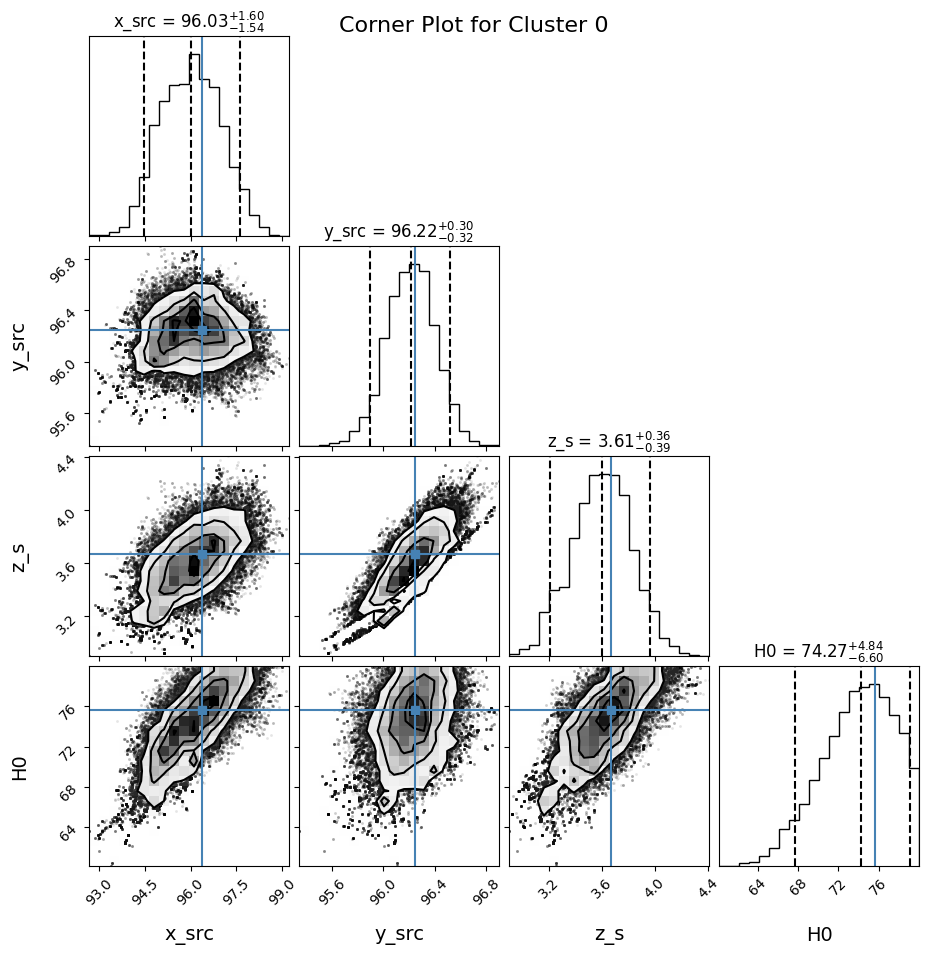

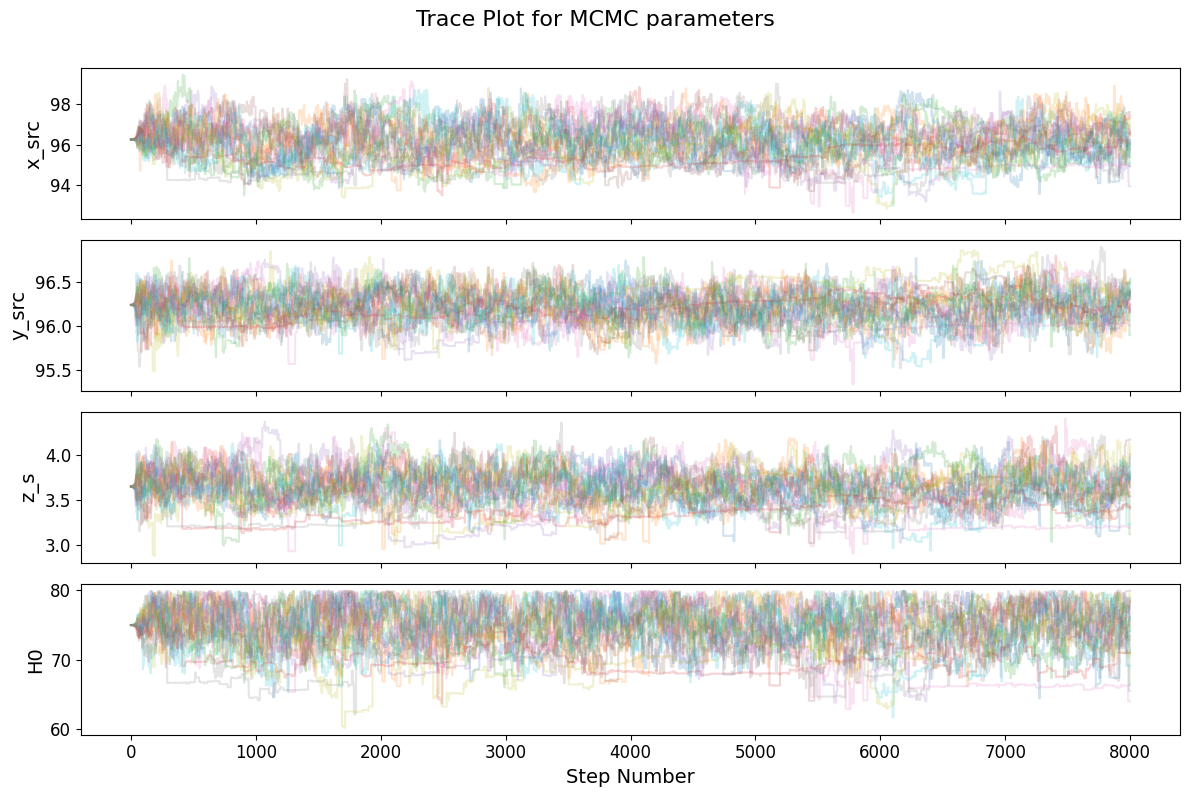

In [27]:
# Plot the corner and trace plots for the saved MCMC results
# Specify the directory where your results are saved
RESULTS_DIR = pathlib.Path("/home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1")
# Specify the index of the cluster you want to plot
CLUSTER_INDEX_TO_PLOT = 0

# Construct the full path to the data file
data_file = os.path.join(RESULTS_DIR, f"cluster_{CLUSTER_INDEX_TO_PLOT}_posterior.npz")

# --- Step 1: Load the Saved Data ---
# Check if the file exists before trying to load it.
if not os.path.exists(data_file):
    print(f"Error: Data file not found at '{data_file}'")
    print("Please make sure you have run the main analysis script first.")
else:
    print(f"Loading data from {data_file}...")
    # np.load returns a dictionary-like object
    mcmc_data = np.load(data_file)

    # You can see what's inside the file by printing the keys
    print("Available data keys:", list(mcmc_data.keys()))

    # Extract the necessary arrays from the loaded data
    flat_chain = mcmc_data['flat_chain']
    full_chain = mcmc_data['chain']
    param_labels = mcmc_data['param_labels']
    truth_values = test_params['x_src'], test_params['y_src'], test_params['z_s'], test_params['H0']

    # --- Step 2: Create the Corner Plot ---
    # The corner plot is the best way to visualize the posterior distributions
    # and the correlations between parameters.

    print("\nGenerating corner plot...")
    
    # The corner.corner function takes the flattened (2D) chain of samples
    # and the labels for each parameter.
    fig_corner = corner.corner(
        flat_chain,
        labels=param_labels,
        quantiles=[0.05, 0.5, 0.95], # 90% intervals
        show_titles=True,
        truths=truth_values,  # If you have true values to plot
        label_kwargs={"fontsize": 14},  # Set axis label font size
        title_kwargs={"fontsize": 12},  # Set title font size
        verbose=False
    )

    fig_corner.suptitle(f"Corner Plot for Cluster {CLUSTER_INDEX_TO_PLOT}", fontsize=16)
    
    # Save the corner plot to a file
    corner_plot_path = os.path.join(RESULTS_DIR, f"cluster_{CLUSTER_INDEX_TO_PLOT}_corner_from_saved.png")
    fig_corner.savefig(corner_plot_path)
    print(f"-> Corner plot saved to {corner_plot_path}")
    

    # --- Step 3: Create the Trace Plot ---
    # A trace plot (or "time series plot") shows the value of each parameter at each
    # step of the MCMC chain for every walker. It is essential for diagnosing
    # convergence. You are looking for a stationary, "fuzzy caterpillar" look,
    # which indicates the walkers are well-mixed and exploring the same parameter space.

    print("\nGenerating trace plot...")
    
    n_steps, n_walkers, n_dim = full_chain.shape
    fig_trace, axes = plt.subplots(n_dim, figsize=(12, 2 * n_dim), sharex=True)
    steps = np.arange(n_steps)

    for i in range(n_dim):
        ax = axes[i]
        # The key command: This plots each of the n_walkers' paths as a separate line.
        ax.plot(steps, full_chain[:, :, i], alpha=0.2)
        ax.set_ylabel(param_labels[i], fontsize=14)
        ax.tick_params(axis='both', labelsize=12)

    axes[-1].set_xlabel("Step Number", fontsize = 14)
    axes[-1].tick_params(axis='both', labelsize=12)
    fig_trace.suptitle(f"Trace Plot for MCMC parameters", fontsize=16, y=0.99)
    fig_trace.tight_layout(rect=[0, 0, 1, 0.98])

    trace_plot_path = os.path.join(RESULTS_DIR, f"cluster_{CLUSTER_INDEX_TO_PLOT}_trace.png")
    fig_trace.savefig(trace_plot_path)
    print(f"-> Trace plot saved to {trace_plot_path}")

    plt.show()